# ModSim Project 3

Casey May and Alex Wenstrup

In [1]:
#Configure notebook and import libaries
from modsim import *
%matplotlib inline

# Question:
### In a binary star system, is it possible to have a planet orbit in a figure 8 pattern, and if so, how stable can we make it and what paramaters are the most influential?


In [2]:
#Define Units
s = UNITS.second
m = UNITS.meter
kg = UNITS.kilogram
N = UNITS.newton

Next, we define the Params object that will contain some of our model parameters. Note that these values are all based off of values in our solar system, with the exception of init_angle. We had to arbitrarily chose a value for the planet's initial trajectory, but that will be swept later in the model.

In [79]:
#Define parameters object
p = Params(init_speed = 30300 * m/s, 
                init_angle = 3 * pi / 4, 
                dist_s = 150e9 * m, 
                mass_s2 = 1e30 * kg)

Here, we define our make_system function. This is the only function in our model which has system parameters hard coded into it. The initial velocities of the suns were calculated (calculations shown below) so that they suns would orbit each other in a perfect circle. We chose to do this because we were more concerned with the planet's behavior than the suns', so modeled their motion as simply as we could. Where possible, our values are based off of distances and masses found in our solar system.

r_final is the distance at which we consider the planet and sun to be too close, causing an orbit we no longer classify as a figure 8.
Likewise, r_escape is the distance at which we consider the planet and sun to be too far, also causing an orbit we no longer classify as a figure 8. We also found that running the simulation for 3000 days was long enough to reach a termination event for most simulations, without taking too long to run.

In [80]:
def make_system(params):
    """Makes a System object.
    
    params: Object containing all the values that may be swept at any time in the model.
    
    returns: System object
    """
    
    unpack(params)
    
    vx,vy = pol2cart(init_angle, init_speed)
   
    init = State(xp = 0 * m, yp = 0 * m,
                vxp = vx * m/s, vyp = vy * m/s,
                xs1 = -dist_s, ys1 = 0 * m,
                vxs1 = 0 * m/s, vys1 = -10543.6 * m/s,
                xs2 = dist_s, ys2 = 0 * m,
                vxs2 = 0 * m/s, vys2 = 10543.6 * m/s)
    return System(params, 
                  init=init,
                  mass_s1 = 1e30 * kg,
                  mass_p = 6e24 * kg,
                  G = 6.67e-11 * N * m ** 2 / kg ** 2,
                  r_final = 5e9 * m,
                  r_escape = 750e9 * m,
                  t_end = 60 * 60 * 24 * 3000 * s)

In [81]:
system = make_system(p)
system

,values
init_speed,30300.0 meter / second
init_angle,2.35619
dist_s,150000000000.0 meter
mass_s2,1e+30 kilogram
init,xp 0...
mass_s1,1e+30 kilogram
mass_p,6e+24 kilogram
G,6.67e-11 meter ** 2 * newton / kilogram ** 2
r_final,5000000000.0 meter
r_escape,750000000000.0 meter


Now, we define the relative positions of all of the bodies of our system. Since our suns will be in an orbit themselves, we need to define their position relative to each other as well as relative to the planet. 

In [82]:
def relative_position1(state):
    """Calculates the position vector of the planet relative to sun 1. 
    
    state: The current state of all three bodies, with position and velocity values
    
    return: Position vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    pos = Vector(xp - xs1, yp - ys1)
    return pos

In [83]:
def relative_position2(state):
    """Calculates the position vector of the planet relative to sun 2. 
    
    state: The current state of all three bodies, with position and velocity values
    
    return: Position vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    pos = Vector(xp - xs2, yp - ys2)
    return pos

In [84]:
def relative_position_s1(state):
    """Calculates the position vector of sun 1 relative to sun 2. 
    
    state: The current state of all three bodies, with position and velocity values
    
    return: Position vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    pos = Vector(xs1 - xs2, ys1 - ys2)
    return pos

In [85]:
def relative_position_s2(state):
    """Calculates the position vector of sun 2 relative to sun 1. 
    
    state: The current state of all three bodies, with position and velocity values
    
    return: Position vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    pos = Vector(xs2 - xs1, ys2 - ys1)
    return pos

Now, we create the gravity functions for our system, that implement the many forces of gravity that belong in our model. We calculated the gravitational force of each sun on the planet individually, and then combined them to be the total force of gravity on the planet. We also calculated the force of gravity between the two suns individually. 

In [86]:
def grav1(state, t, system):
    """Calculates the gravitational force vector of sun 1 on the planet. 
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: Force vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)
    pos = relative_position1(state)
    force_mag = -G * mass_s1 * mass_p / (pos.mag ** 2)
    force_dir = pos.hat()
    force = force_dir * force_mag
    return force

In [87]:
def grav2(state, t, system):
    """Calculates the gravitational force vector of sun 2 on the planet. 
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: Force vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)
    pos = relative_position2(state)
    force_mag = -G * mass_s2 * mass_p / (pos.mag ** 2)
    force_dir = pos.hat()
    force = force_dir * force_mag
    return force

In [88]:
def grav_s1(state, t, system):
    """Calculates the gravitational force vector of sun 2 on sun 1. 
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: Force vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)
    pos = relative_position_s1(state)
    force_mag = -G * mass_s1 * mass_s2 / (pos.mag ** 2)
    force_dir = pos.hat()
    force = force_dir * force_mag
    return force

In [89]:
def grav_s2(state, t, system):
    """Calculates the gravitational force vector of sun 1 on sun 2. 
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: Force vector
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)
    pos = relative_position_s2(state)
    force_mag = -G * mass_s1 * mass_s2 / (pos.mag ** 2)
    force_dir = pos.hat()
    force = force_dir * force_mag
    return force

In [90]:
def gravp(state, t, system):
    """Calculates the total gravitational force of boths suns on the planet. 
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: Force vector
    """
    return grav1(state, t, system) + grav2(state, t, system)

Now, we create a slope function and put in all our differential equations.

In [91]:
def slope_func(state, t, system):
    """Implementation of our system of differential equations 
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: The change in all state variables in one time step (12 floating point numbers)
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)  
    
    xhat = Vector(1, 0)
    yhat = Vector(0, 1)
    
    r1= relative_position1(state)
    r2= relative_position2(state)
    forcep = gravp(state, t, system)
    force_s1 = grav_s1(state, t, system)
    force_s2 = grav_s2(state, t, system)
    
    dxpdt = vxp
    dypdt = vyp
    ds1xdt = vxs1
    ds1ydt = vys1
    ds2xdt = vxs2
    ds2ydt = vys2
    
    dvxpdt = forcep.dot(xhat) / mass_p
    dvypdt = forcep.dot(yhat) / mass_p
    dvxs1dt = force_s1.dot(xhat) / mass_s1
    dvys1dt = force_s1.dot(yhat) / mass_s1
    dvxs2dt = force_s2.dot(xhat) / mass_s2
    dvys2dt = force_s2.dot(yhat) / mass_s2
    
    
    return dxpdt, dypdt, dvxpdt, dvypdt, ds1xdt, ds1ydt, dvxs1dt, dvys1dt, ds2xdt, ds2ydt, dvxs2dt, dvys2dt 

Next, we created four event functions that end the simulation in the case of a termination event . Our first two event functions were created to account for if the planet ever fell into one of the two stars. Each of those two event functions were created for one of the two stars. The third and fourth event functions were created for the possibility of the planet escaping the orbit of one of the stars, because without these event functions our model would not account for the possibility of a planet being slung out of the orbit and into the depths of space. 

In [92]:
def event_func1(state, t, system):
    """Event function for planet nearing sun 1
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: The difference between our planets position relative to sun 1 and our collision threshold
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)  
    
    pos = relative_position1(state)
    return pos.mag - r_final

In [93]:
def event_func2(state, t, system):
    """Event function for planet nearing sun 2
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: The difference between our planets position relative to sun 2 and our collision threshold
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)  
    
    pos = relative_position2(state)
    return pos.mag - r_final

In [94]:
def event_func3(state, t, system):
    """Event function for the planet permanently escapting the orbit of sun 1
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: The difference between our planets position relative to sun 1 and our escape threshold
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)  
    
    pos = relative_position1(state)
    return r_escape - pos.mag

In [95]:
def event_func4(state, t, system):
    """Event function for the planet permanently escapting the orbit of sun 2
    
    state: The current state of all three bodies, with position and velocity values
    t: The current time step in the simulation
    system: Object containing all of the model parameters
    
    return: The difference between our planets position relative to sun 2 and our escape threshold
    """
    xp, yp, vxp, vyp, xs1, ys1, vxs1, vys1, xs2, ys2, vxs2, vys2 = state
    unpack(system)  
    
    pos = relative_position2(state)
    return r_escape - pos.mag

In [96]:
#prints what happened in the simulation
results, details = run_ode_solver(system, slope_func, events=(event_func1, event_func2, event_func3, event_func4))
details

,values
sol,None
t_events,"[[], [], [], [129405923.74402884]]"
nfev,374
njev,0
nlu,0
status,1
message,A termination event occurred.
success,True


In [97]:
details.t_events[0].size

0

In [98]:
#converting units
results.index /= 60 * 60 * 24
results.xp /= 1e9
results.yp /= 1e9
results.xs1 /= 1e9
results.ys1 /= 1e9
results.xs2 /= 1e9
results.ys2 /= 1e9

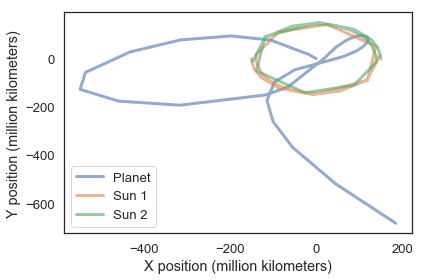

In [99]:
#plotting the orbit
plot(results.xp, results.yp, label='Planet')
plot(results.xs1, results.ys1, label='Sun 1')
plot(results.xs2, results.ys2, label='Sun 2')

decorate(xlabel='X position (million kilometers)',
         ylabel='Y position (million kilometers)')

Now we created our time function so that we can eventually use the same time stopped at by the event function to sweep our variables. When plugged in to all of our sweeps, we can see the most effective parameter changes for that amount of time. 

In [24]:
def time_func(parameters):
    """Extracts time of event function from details of one simulation
    
    parameters: Params object passed to the system, setting model parameters
    
    return: Time of the event function
    """
    system = make_system(parameters)
    results, deets = run_ode_solver(system, slope_func, events=(event_func1, event_func2, event_func3, event_func4))
    t = system.t_end
    for time in deets.t_events:
        if time.size == 1:
            t = time[0]
    return t

Our first sweep is to determine the best angle for the stability of our figure eight orbit. When we run our sweep_angle, it gives us the amount of time the orbit lasted for, which by itself doesn't guarantee that the planet went in a figure 8 orbit, it just suggests that it was reasonably stable. In order to clarify that the planet did take a figure eight path, we have to plug the optimal angles back into our initial conditions and then look at the plot that is eventually created with that information. 

In [25]:
def sweep_angle(angles):
    """Sweeps through a range of initial angles for the planets trajectory, 
       running one simulation for each angle
    
    angles: Range of angles to be swept through
    
    return: Sweep Series, where the values are the times that the orbit 'collapsed'
    """
    sweep = SweepSeries()

    for angle in angles:
        parameters = Params(p, init_angle = angle)
        time = time_func(parameters)
        sweep[angle] = time
        
    return sweep

init_speed    30300.0 meter / second
init_angle                   2.35619
dist_s          150000000000.0 meter
mass_s2               1e+30 kilogram
dtype: object


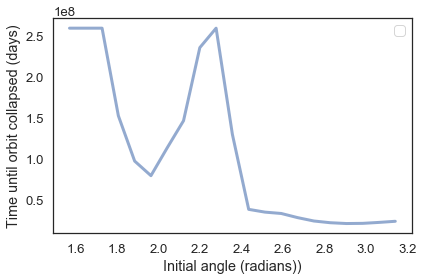

In [26]:
print(p)
angles = linspace(pi/2, pi, 21)
sweep = sweep_angle(angles)
plot(sweep)

decorate(xlabel='Initial angle (radians))',
         ylabel='Time until orbit collapsed (days)')

In [27]:
sweep

,values
1.570796,259200000 second
1.649336,259200000 second
1.727876,259200000 second
1.806416,1.52178e+08
1.884956,9.68422e+07
1.963495,7.90064e+07
2.042035,1.13116e+08
2.120575,1.4612e+08
2.199115,2.35426e+08
2.277655,259200000 second


Our next sweep, speed_speed, went through the possibilites of speeds and how stable of an orbit they would make. This also outputs a graph that lets us know which of the simulations made it all the way through the set time without reaching a termination event, and therefore gives us good data points to try to plug back into the initial system.  

In [28]:
def sweep_speed(speeds):
    """Sweeps through a range of initial planetary speeds, 
       running one simulation for each speed
    
    speeds: Range of speeds to be swept through
    
    return: Sweep Series, where the values are the times that the orbit 'collapsed'
    """
    sweep = SweepSeries()

    for speed in speeds:
        parameters = Params(p, init_speed = speed)
        time = time_func(parameters)
        sweep[speed] = time
        
    return sweep

init_speed    30300.0 meter / second
init_angle                   2.35619
dist_s          150000000000.0 meter
mass_s2               1e+30 kilogram
dtype: object


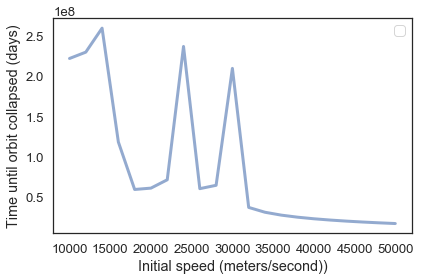

In [29]:
print(p)
speeds = linspace(10000, 50000, 21)
sweep = sweep_speed(speeds)
plot(sweep)

decorate(xlabel='Initial speed (meters/second))',
         ylabel='Time until orbit collapsed (days)')

In [30]:
sweep

,values
10000,2.21603e+08
12000,2.29472e+08
14000,259200000 second
16000,1.18048e+08
18000,5.91962e+07
20000,6.0871e+07
22000,7.12169e+07
24000,2.36539e+08
26000,6.02163e+07
28000,6.43632e+07


Assumptions: Our model made a variety of assumptions. We assumed that our system would have no other small bodies or items contributing gravitational force. We assumed that the planet would create no gravitational pull for the two stars. We also assumed that the planet we are introducing could be inserted equidistant from both suns at the point of introduction. For the most part, these assumptions don't take away from the relevance of the model.

Relevance: The importance of this model isn't difficult to pick out. The existence of figure 8 orbits rely on their feasability and stability, and knowing the conditions under which they exist can make it that much easier to pick out a system that exists in real life. 

# Conclusion
We found that, in our model, it is very possible for a figure eight orbit to exist around to revolving stars in a binary star system. This could be losely applied to astronomy, taking into account the limitations our model had. We also found that the speed and angle of introduction of the planet have an almost equally important effect on the stability of the orbit. Although it is difficult to quantify their influential nature, it is reasonable to say that the most important parameter when it comes to creating a stable figure 8 orbit is the angle of its introduction, because there were some angles that, no matter what the speed, could not create a stable orbit. 